This is looking for additional cuts to veto cosmic events,

and tighten dsamuon preselections to avoid unphysical giant pT.

In [1]:
import json
import awkward
import numpy as np
import matplotlib.pyplot as plt
from coffea.analysis_objects import JaggedCandidateArray
from coffea import hist
import coffea.processor as processor
np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [33]:
class DebugProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        paralledsa_axis = hist.Bin('pdsa', '# parallel dsa pairs', 20, 0, 20)
        parallelcosmic_axis = hist.Bin('pcosmic', '# parallel cosmic pairs', 20, 0, 20)
        pterroroverpt_axis = hist.Bin('pterroverpt', 'dSA $\sigma_{p_T}/p_T$', 50, 0, 25)
        
        self._accumulator = processor.dict_accumulator({
            'numparadsa': hist.Hist("Events", dataset_axis, paralledsa_axis),
            'numparacos': hist.Hist("Events", dataset_axis, parallelcosmic_axis),
            "pterroverpt": hist.Hist("#counts", dataset_axis, pterroroverpt_axis)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        pterroverpt = awkward.fromiter(df['ljmisc_dsaPtError'])/awkward.fromiter(df['ljmisc_dsaPt'])
        pterroverpt = pterroverpt[matchmask]
        
        output['numparadsa'].fill(dataset=dataset, pdsa=df['ljmisc_numParallelDsa'])
        output['numparacos'].fill(dataset=dataset, pcosmic=df['ljmisc_numParallelCosmic'])
        output['pterroverpt'].fill(dataset=dataset, pterroverpt=pterroverpt.flatten().flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

## lxy: 0.3cm

In [44]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=DebugProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


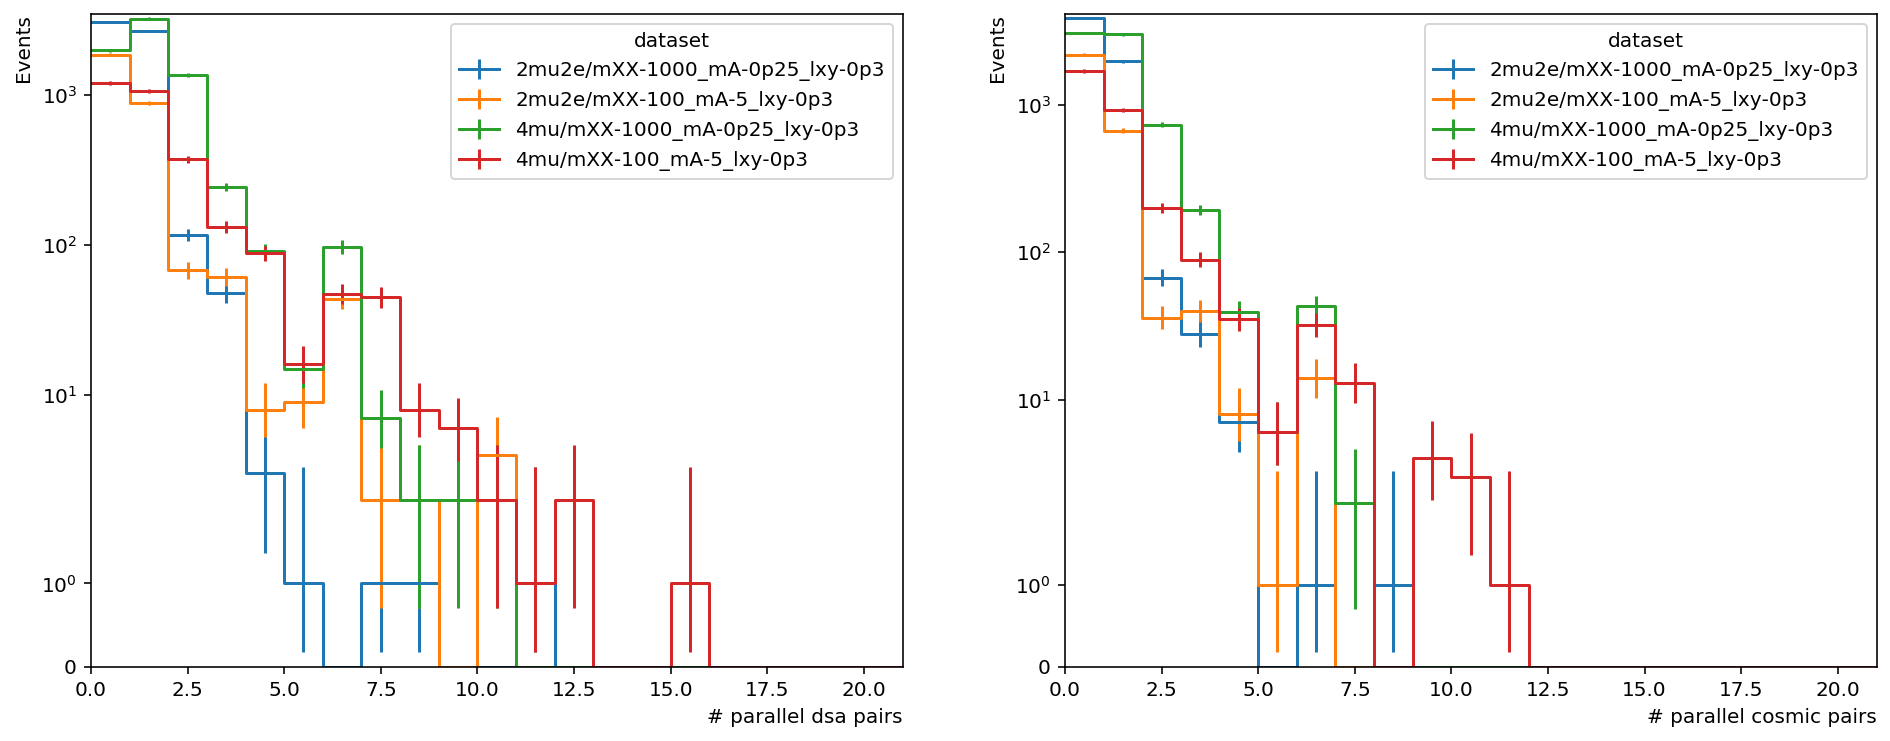

In [45]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['numparadsa'], overlay='dataset', overflow='over', ax=axes[0])
hist.plot1d(output['numparacos'], overlay='dataset', overflow='over', ax=axes[1])
for ax in axes:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

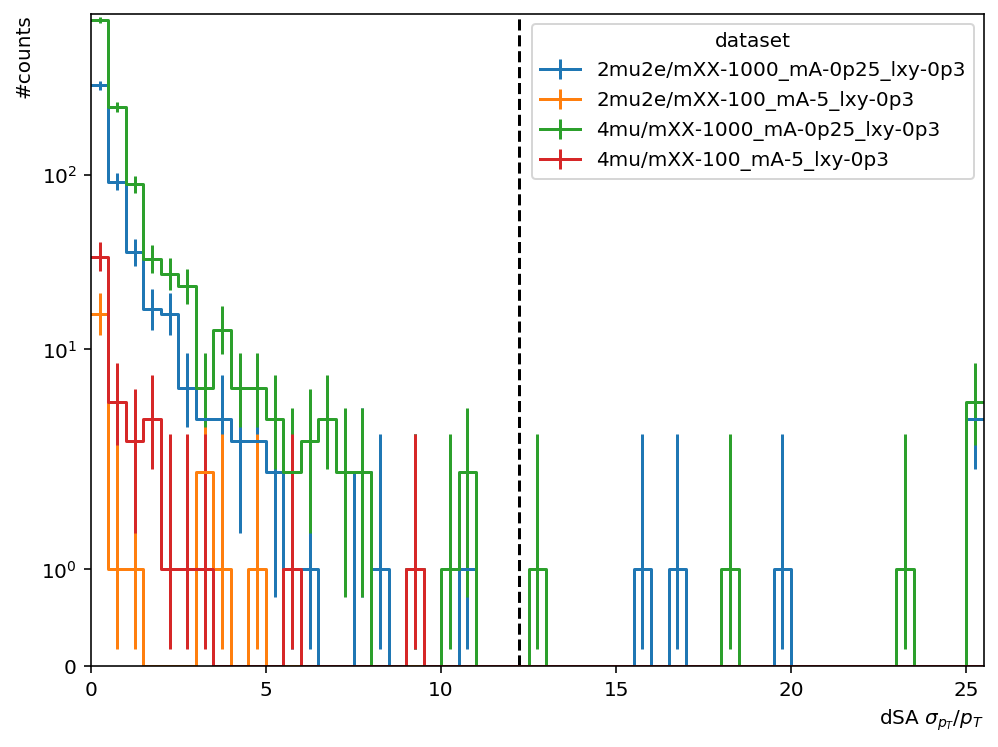

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(output['pterroverpt'], overlay='dataset', overflow='over', ax=ax)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.vlines(10/25, 0, 1, linestyles='--', transform=ax.transAxes);

In [46]:
for k, v in output['pterroverpt'].values(overflow='over').items():
    print('{:30} | {:.3f}'.format(k[0], v[: 10*2].sum()/v.sum()))

4mu/mXX-100_mA-5_lxy-0p3       | 1.000
4mu/mXX-1000_mA-0p25_lxy-0p3   | 0.991
2mu2e/mXX-1000_mA-0p25_lxy-0p3 | 0.985
2mu2e/mXX-100_mA-5_lxy-0p3     | 1.000


## lxy:300cm

In [37]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300': dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename="ffNtuplizer/ffNtuple",
                                  processor_instance=DebugProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


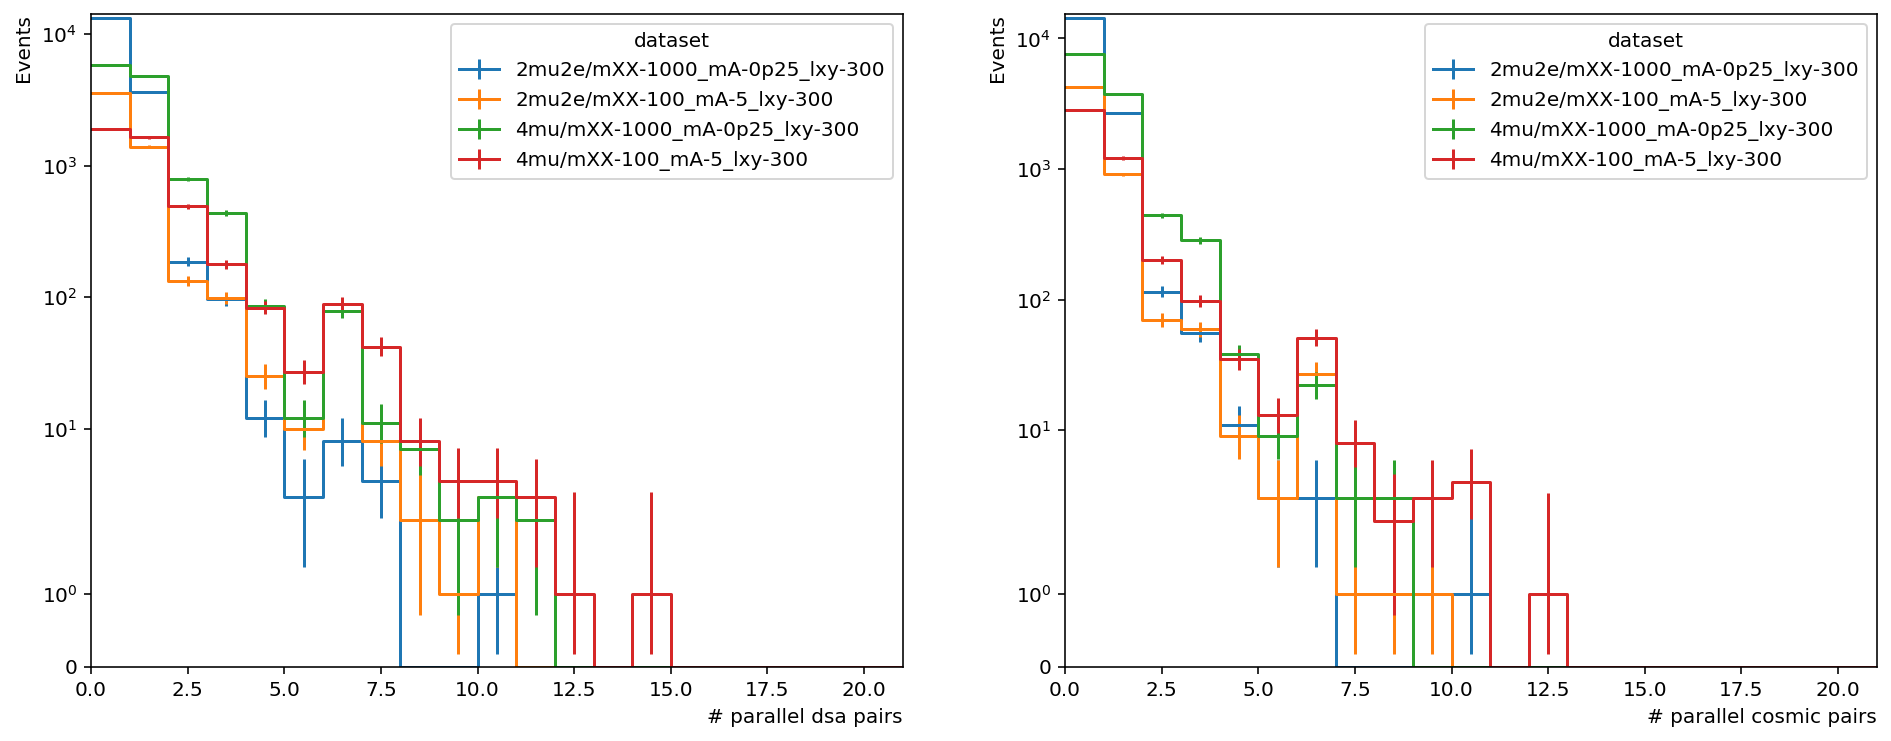

In [38]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['numparadsa'], overlay='dataset', overflow='over', ax=axes[0])
hist.plot1d(output['numparacos'], overlay='dataset', overflow='over', ax=axes[1])
for ax in axes:
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

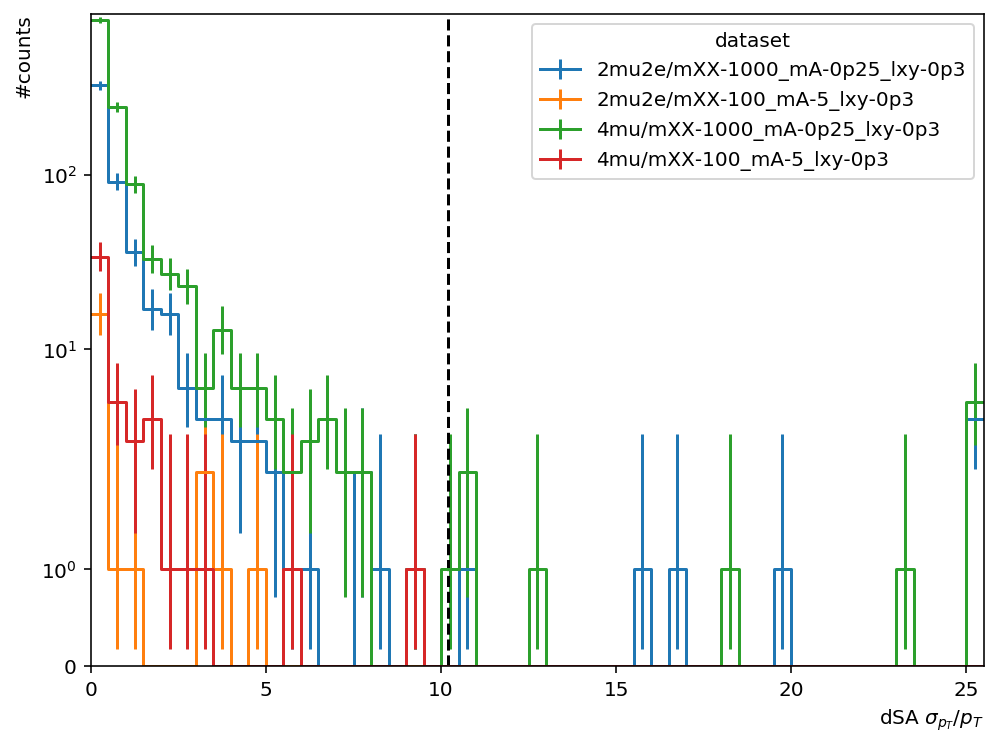

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(output['pterroverpt'], overlay='dataset', overflow='over', ax=ax)
ax.set_yscale('symlog')
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.vlines(10/25, 0, 1, linestyles='--', transform=ax.transAxes);

In [42]:
for k, v in output['pterroverpt'].values(overflow='over').items():
    print('{:30} | {:.3f}'.format(k[0], v[: 10*2].sum()/v.sum()))

4mu/mXX-100_mA-5_lxy-300       | 0.991
2mu2e/mXX-100_mA-5_lxy-300     | 0.990
4mu/mXX-1000_mA-0p25_lxy-300   | 0.986
2mu2e/mXX-1000_mA-0p25_lxy-300 | 0.986
